# Определение перспективного тарифа для телеком компании

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файла

Импортируем библиотеки, нужные для проведения анализа.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats as st
import numpy as np

Получим файлы с данными и сохраним их.

In [3]:
def return_df (name_csv):
    try:
        return pd.read_csv(name_csv)
    except:
        print('Не удалось найти файл по заданному пути.')

In [4]:
calls = return_df('/datasets/calls.csv')
internet = return_df('/datasets/internet.csv')
messages = return_df('/datasets/messages.csv')
tariffs = return_df('/datasets/tariffs.csv')
users = return_df('/datasets/users.csv')

Выведем таблицу 'users' и посмотрим на её содержимое.

In [5]:
users.head(10)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
5,1005,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart
6,1006,21,NaN,Ульяновск,Леонид,Ермолаев,2018-02-26,smart
7,1007,65,NaN,Москва,Юна,Березина,2018-04-19,smart
8,1008,63,NaN,Челябинск,Рустэм,Пономарёв,2018-12-19,smart
9,1009,24,NaN,Пермь,Василиса,Блинова,2018-03-22,smart


А вот и первые пропуски. Выведем информацию о данной таблице.

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В таблице 'users' всего 8 столбцев.

* user_id — уникальный идентификатор пользователя
* first_name — имя пользователя
* last_name — фамилия пользователя
* age — возраст пользователя (годы)
* reg_date — дата подключения тарифа (день, месяц, год)
* churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* city — город проживания пользователя
* tarif — название тарифного плана

Количество значений в столбцах различается, это говорит о том, что в нашей таблице есть пропуски.

Рассмотрим следующими таблицы 'internet', 'calls', 'messeges'.

In [7]:
internet.head(10)

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
5,5,1000_5,399.97,2018-10-02,1000
6,6,1000_6,540.08,2018-09-07,1000
7,7,1000_7,415.70,2018-07-11,1000
8,8,1000_8,505.40,2018-10-08,1000
9,9,1000_9,345.54,2018-09-03,1000


In [8]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В таблице 'internet' 5 столбцев, из которых один 'Unnamed: 0', выглядит, как дубликация индексов, его нужно будет убрать.

Таблица 'internet' несет в себе информацию о интернет-сессиях.

* id — уникальный номер сессии
* mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
* session_date — дата интернет-сессии
* user_id — идентификатор пользователя

In [9]:
pd.read_csv('/datasets/internet.csv', index_col = 0)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [10]:
calls.head(10)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
5,1000_5,2018-11-02,0.00,1000
6,1000_6,2018-10-18,0.00,1000
7,1000_7,2018-08-22,18.31,1000
8,1000_8,2018-09-15,18.44,1000
9,1000_9,2018-08-15,0.00,1000


In [11]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Таблица 'calls' содержит в себе информацию о звонках, сделанных в сети компании 'Мегалайн'.

* id — уникальный номер звонка
* call_date — дата звонка
* duration — длительность звонка в минутах
* user_id — идентификатор пользователя, сделавшего звонок

In [12]:
messages.head(10)

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
5,1000_5,2018-06-20,1000
6,1000_6,2018-11-19,1000
7,1000_7,2018-10-29,1000
8,1000_8,2018-06-25,1000
9,1000_9,2018-12-18,1000


In [13]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


'messages' - таблица с информацией об отправленных сообщениях. Она содержит 3 стобца:
    
* id — уникальный номер сообщения
* message_date — дата сообщения
* user_id — идентификатор пользователя, отправившего сообщение

Наконец, выведем данные из последней таблицы 'tariffs'.

In [14]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


В таблице всего 2 значения - это условия пользования по двум тарифным планам. Значения столбцев:
    
* tariff_name — название тарифа
* rub_monthly_fee — ежемесячная абонентская плата в рублях
* minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
* messages_included — количество сообщений в месяц, включённых в абонентскую плату
* mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
* rub_per_message — стоимость отправки сообщения сверх тарифного пакета
* rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Вывод

Наши данные - это данные компании 'Мегалайн' о действиях клиентов. Данные разбиты на таблицы, каждая отвечает за определенный раздел информации. Прежде чем приступать к анализу данных, нужно привести данные к "нормальному" виду. 

## Подготовка данных

Что нужно сделать?

* Провести предобработку
* Затем добавим некую информацию к нашим таблицам:
        - количество сделанных звонков и израсходованных минут разговора по месяцам;
        - количество отправленных сообщений по месяцам;
        - объем израсходованного интернет-трафика по месяцам;
        - помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Сначала разберемся с пропусками. Вспомнил, что при знакомстве с данными пропуски мы увидели только в таблице 'users', рассмотрим их поподробней.

In [15]:
report = users.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / users.shape[0]).round(2)
report.style.background_gradient(cmap = 'RdPu')

,missing_values,% of total
user_id,0,0
age,0,0
churn_date,462,0.92
city,0,0
first_name,0,0
last_name,0,0
reg_date,0,0
tariff,0,0


Пропусков очень много, удаляем столбец? Прежде чем принимать такие ключевые решения, давайте вспомним, какая информация хранится в этом столбце. 
'churn_date' — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных).
В самом описании данных указано, что пропуски - это не ошибки. Значит удалять мы их не будем. А чем же их заполнять? Для этого предлагаю сначала посмотреть на диапазон наших значений.

In [16]:
users['churn_date'].value_counts()

2018-12-21    2
2018-10-14    2
2018-10-03    2
2018-12-09    2
2018-12-03    2
2018-12-26    1
2018-12-18    1
2018-11-22    1
2018-10-25    1
2018-11-27    1
2018-11-21    1
2018-12-11    1
2018-11-13    1
2018-08-31    1
2018-10-28    1
2018-11-07    1
2018-09-26    1
2018-09-02    1
2018-11-26    1
2018-10-05    1
2018-08-17    1
2018-12-20    1
2018-12-24    1
2018-09-27    1
2018-12-30    1
2018-12-16    1
2018-10-04    1
2018-12-25    1
2018-12-23    1
2018-11-16    1
2018-10-27    1
2018-12-14    1
2018-11-30    1
Name: churn_date, dtype: int64

Рискну предположить, что нам предоставили данные компании 'Мегалайн' за 2018 год, поэтому для заполнения пропусков я предлагаю следующий маркер. на момент 1ого января 2019 года все клиенты с пропущенными значениями все ещё являются клиентами 'Мегалайн', поэтому этими значениями и заполним пропуски, но будем держать эту информацию в голове при анализе.

In [17]:
users['churn_date'] = users['churn_date'].fillna('2019-01-01')

In [18]:
users['churn_date'].isna().sum()

0

Пропущенные значения победили. Теперь решим следующую проблему. У нас очень много данных с датами, а хранятся они как object. Давайте исправим это.

In [19]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
# пытался это сделать в цикле, в лист засунул все столбцы, по одному передавал их в цикл
#и менял тип данных, тип данныз в serios менялся, но не изменял столбец в самом dataframe

In [38]:
list = [internet['session_date'], calls['call_date']]
for series in list:
    series = pd.to_datetime(series, format = '%Y-%m-%d')

0         2018-11-25
1         2018-09-07
2         2018-06-25
3         2018-08-22
4         2018-09-24
             ...    
149391    2018-10-03
149392    2018-12-14
149393    2018-10-27
149394    2018-11-26
149395    2018-10-26
Name: session_date, Length: 149396, dtype: object
0         2018-07-25
1         2018-08-17
2         2018-06-11
3         2018-09-21
4         2018-12-15
             ...    
202602    2018-12-26
202603    2018-10-18
202604    2018-11-10
202605    2018-10-06
202606    2018-12-14
Name: call_date, Length: 202607, dtype: object


Проверим, все ли у нас получилось.

In [20]:
print('session_date -',type(internet['session_date']))
print('call_date -',type(calls['call_date']))
print('message_date -',type(messages['message_date']))
print('reg_date -',type(users['reg_date']))
print('churn_date -',type(users['churn_date']))

session_date - <class 'pandas.core.series.Series'>
call_date - <class 'pandas.core.series.Series'>
message_date - <class 'pandas.core.series.Series'>
reg_date - <class 'pandas.core.series.Series'>
churn_date - <class 'pandas.core.series.Series'>


Вспоминаем о столбце 'Unnamed: 0' из таблицы 'internet'. Он дублирует в себе значения индексов, а зачем нам это нужно?! Удаляем его.

In [21]:
del internet['Unnamed: 0']

In [22]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [23]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null datetime64[ns]
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


Ещё один из пунктов предобработки данных - это работа с дубликатами. В контексте нашей работы, считаю, что нам нужно лишь проверить, присутствуют ли у нас дубликаты звонков, сообщений и сессий в интернет. Это можно сделать по уникальном id каждого действия. Остальные данные можно не проверять, в частности таблицу 'users', так как часто бывает, что на одного человека зарегистрировано несколько сим-карт.

In [24]:
calls['id'].duplicated().sum()

0

In [25]:
messages['id'].duplicated().sum()

0

In [26]:
internet['id'].duplicated().sum()

0

Дубликатов не обнаружено. Переходим к следующей части подготовки наших данных. Рассчитаем для каждого пользователя количество сделанных звонков и израсходованных минут разговора по месяцам. 

Для этого сначала уберем из таблицы 'calls' все строки, где значение столбца 'duration' равны нулю. Деньги или минуты не списываются за не отвеченные звонки. А учитывать эти звонки при подсчете количества звонков, мне кажется, не правильно.
Затем создадим новы столбец 'month', чтобы было удобнее группировать нашу таблицу (так как в нашей статистике предоставлены данные только за 2018 год, то номера месяца будет достаточно). Так же округлим минуты в наших данных в большую сторону (такие правила списания у компании 'Мегалайн'). Ну и сгруппируем нашу таблицу по значениям 'user_id' и 'month' и посчитаем количество звонком и сумму израсходованных минут.

In [27]:
calls = calls.query('duration != 0')

In [28]:
calls['duration'] = calls['duration'].apply(lambda duration: math.ceil(duration))

In [29]:
calls['month'] = calls['call_date'].apply(lambda call_date: call_date.month)

In [30]:
calls_by_month = calls.pivot_table(
    index = ['user_id','month'], values = 'duration', aggfunc = ['count','sum']
)

In [31]:
#переименуем столбцы, избавимся от двойных названий
calls_by_month.columns = ('count_calls', 'total_minutes')

In [32]:
calls_by_month

count_calls  total_minutes
user_id month                            
1000    5               17            159
        6               28            172
        7               41            340
        8               42            408
        9               46            466
...                    ...            ...
1498    10              30            247
1499    9                8             70
        10              44            449
        11              62            612
        12              56            492

[3168 rows x 2 columns]

Сделано! Переходим к следующей задаче, посчитаем количество отправленных сообщений по месяцам.

С таблицей 'messages' поступаем похожим образом. Только округлять нам ничего не нужно, и считать будем только количество смс, от количества символов в ней цена не меняется.

In [33]:
messages['month'] = messages['message_date'].apply(lambda message_date: message_date.month)

In [34]:
messages_by_month = messages.pivot_table(
    index = ['user_id','month'], values = 'id', aggfunc = 'count'
)

In [35]:
messages_by_month.columns = ['total_messages']

In [36]:
messages_by_month

total_messages
user_id month                
1000    5                  22
        6                  60
        7                  75
        8                  81
        9                  57
...                       ...
1498    10                 42
1499    9                  11
        10                 48
        11                 59
        12                 66

[2717 rows x 1 columns]

Пришла очередь интернета. Берём таблицу 'internet' и проделываем с ней то же, что делали с предыдущими.

In [37]:
internet['month'] = internet['session_date'].apply(lambda session_date: session_date.month)
internet

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


In [38]:
internet_by_month = internet.pivot_table(
    index = ['user_id','month'], values = 'mb_used', aggfunc = 'sum'
)

In [39]:
internet_by_month.columns = ['internet_used']

In [40]:
internet_by_month

internet_used
user_id month               
1000    5            2253.49
        6           23233.77
        7           14003.64
        8           14055.93
        9           14568.91
...                      ...
1498    10          20579.36
1499    9            1845.75
        10          17788.51
        11          17963.31
        12          13055.58

[3203 rows x 1 columns]

In [41]:
internet_by_month['internet_used'] = internet_by_month['internet_used'].apply(
    lambda internet_used: math.ceil(internet_used / 1024)
)

In [42]:
internet_by_month

internet_used
user_id month               
1000    5                  3
        6                 23
        7                 14
        8                 14
        9                 15
...                      ...
1498    10                21
1499    9                  2
        10                18
        11                18
        12                13

[3203 rows x 1 columns]

In [43]:
internet_by_month.query('internet_used == 0').count()

internet_used    2
dtype: int64

А мы нашли какие-то аномальные значения, хм... если без шуток, оказывается ещё остались люди, которые не пользуются интернетом на своем телефоне.

Теперь нужно рассчитать помесячную выручку с каждого пользователя. Для этого объединим 3 наши таблицы. В полученной таблице создадим новый столбец, который будет хранить сумму, которую клиент заплатил телекомпании за месяц. Для этого создадим функцию, которая, обращаясь к таблице 'tariffs', будет рассчитывать, сколько клиент заплатил компании.

In [44]:
#объединяем наши 3 таблицы.
stat_users = calls_by_month.join([messages_by_month, internet_by_month], how='outer')

In [45]:
#проверим, появились ли пропуски
stat_users.isna().sum()

count_calls        46
total_minutes      46
total_messages    497
internet_used      11
dtype: int64

In [46]:
# пропуски говорят нам о том - что клиент не использовал тот или иной вид связи
# так что заполняем их нулями
stat_users = stat_users.fillna(0)

In [47]:
stat_users = stat_users.reset_index()

In [48]:
#посмотрим на нашу таблицу
stat_users.head(10)

,user_id,month,count_calls,total_minutes,total_messages,internet_used
0,1000,5,17.0,159.0,22.0,3.0
1,1000,6,28.0,172.0,60.0,23.0
2,1000,7,41.0,340.0,75.0,14.0
3,1000,8,42.0,408.0,81.0,14.0
4,1000,9,46.0,466.0,57.0,15.0
5,1000,10,44.0,350.0,73.0,15.0
6,1000,11,37.0,338.0,58.0,15.0
7,1000,12,38.0,333.0,70.0,10.0
8,1001,11,45.0,430.0,0.0,18.0
9,1001,12,47.0,414.0,0.0,14.0


Можно заметить, что некоторые данные у нас с плавающей запятой, но нам это не нужно. Давайте переопределим их в целочисленный тип.

In [49]:
columns = ['count_calls', 'total_minutes', 'total_messages', 'internet_used']
for column in columns:
    stat_users[column] = stat_users[column].astype('int')

In [50]:
stat_users.head(10)

,user_id,month,count_calls,total_minutes,total_messages,internet_used
0,1000,5,17,159,22,3
1,1000,6,28,172,60,23
2,1000,7,41,340,75,14
3,1000,8,42,408,81,14
4,1000,9,46,466,57,15
5,1000,10,44,350,73,15
6,1000,11,37,338,58,15
7,1000,12,38,333,70,10
8,1001,11,45,430,0,18
9,1001,12,47,414,0,14


Для дальнейших расчетов добавим новый столбец 'tariff' и столбец 'churn_date' в нашу таблицу.

In [51]:
users_tariffs = users['user_id'].to_frame()
users_tariffs['tariff'] = users['tariff']
users_tariffs['churn_date'] = users['churn_date']
users_tariffs

,user_id,tariff,churn_date
0,1000,ultra,2019-01-01
1,1001,smart,2019-01-01
2,1002,smart,2019-01-01
3,1003,ultra,2019-01-01
4,1004,ultra,2019-01-01
...,...,...,...
495,1495,ultra,2019-01-01
496,1496,smart,2019-01-01
497,1497,smart,2019-01-01
498,1498,smart,2018-10-25


In [52]:
stat_users = stat_users.merge(users_tariffs, on = 'user_id')
stat_users

,user_id,month,count_calls,total_minutes,total_messages,internet_used,tariff,churn_date
0,1000,5,17,159,22,3,ultra,2019-01-01
1,1000,6,28,172,60,23,ultra,2019-01-01
2,1000,7,41,340,75,14,ultra,2019-01-01
3,1000,8,42,408,81,14,ultra,2019-01-01
4,1000,9,46,466,57,15,ultra,2019-01-01
...,...,...,...,...,...,...,...,...
3209,1498,10,30,247,42,21,smart,2018-10-25
3210,1499,9,8,70,11,2,smart,2019-01-01
3211,1499,10,44,449,48,18,smart,2019-01-01
3212,1499,11,62,612,59,18,smart,2019-01-01


Так намного лучше. Теперь напишем функцию для расчета месячной выручки с каждого клиента. Сначала будем смотреть, к какому тарифу подключен наш пользователь и добавлять в значение выручки ежемесячную плату. Затем рассчитываем цену за минуты разговора, сообщения и объём интернет-трафика, которые клиент использовал сверх тарифного плана.

In [53]:
def calculation_of_costs(raw):
    total_paid = 0
    tariff = raw['tariff']
    total_minutes = raw['total_minutes']
    total_messages = raw['total_messages']
    internet_used = raw['internet_used']
    
    if tariff == 'ultra':
        total_paid += 1950
        minutes_included = 3000
        rub_per_minute = 1
        messages_included = 1000
        rub_per_message = 1
        mb_per_month_included = 30
        rub_per_gb = 150
    if tariff == 'smart':
        total_paid += 550
        minutes_included = 500
        rub_per_minute = 3
        messages_included = 50
        rub_per_message = 3
        mb_per_month_included = 15
        rub_per_gb = 200      
        
    if total_minutes > minutes_included:
        total_paid += (total_minutes - minutes_included) * rub_per_minute
    if total_messages > messages_included:
        total_paid += (total_messages - messages_included) * rub_per_message
    if internet_used > mb_per_month_included:
        total_paid += (internet_used - mb_per_month_included) * rub_per_gb
    return total_paid

In [54]:
stat_users['total_costs'] = stat_users.apply(calculation_of_costs, axis = 1)

In [55]:
stat_users

,user_id,month,count_calls,total_minutes,total_messages,internet_used,tariff,churn_date,total_costs
0,1000,5,17,159,22,3,ultra,2019-01-01,1950
1,1000,6,28,172,60,23,ultra,2019-01-01,1950
2,1000,7,41,340,75,14,ultra,2019-01-01,1950
3,1000,8,42,408,81,14,ultra,2019-01-01,1950
4,1000,9,46,466,57,15,ultra,2019-01-01,1950
...,...,...,...,...,...,...,...,...,...
3209,1498,10,30,247,42,21,smart,2018-10-25,1750
3210,1499,9,8,70,11,2,smart,2019-01-01,550
3211,1499,10,44,449,48,18,smart,2019-01-01,1150
3212,1499,11,62,612,59,18,smart,2019-01-01,1513


Сделано! Теперь у нас есть таблица, где по месяцам для каждого клиента хранится информация о израсходованных минутах, сообщений и интернет-трафике и рассчитано выручку, которую заработала компания 'Мегалайн' с этого клиента.

### Вывод

Мы подготовили наши данные к анализу. Совершили предобработку данных. Затем мы создали новую таблицу с данными, которые необходимы для дальнейшего анализа. В этой таблице хранятся данные о расходах по тарифному плану каждого клиента по месяцам и посчитана ежемесячная выручка телекомпании. С подготовкой данных мы разобрались, переходим к анализу.

## Анализ данных

В этой части работы нам нужно описать поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц?
Посчитаем среднее количество, дисперсию и стандартное отклонение. Построим гистограммы. Опишем распределения.

Посчитаем среднее количество, дисперсию и стандартное отклонение. Для каждого из наших значений. Затем построим гистограммы распределения.

Для начала рассчитаем среднюю месечную оплату пользователей разных тарифов. И общую выручку с каждого тарифа.

In [56]:
print('Средние затраты в месяц пользователей тарифа "ultra":',stat_users.query('tariff == "ultra"')['total_costs'].mean())
print('Общая выручка с пользователей тарифа "ultra":',stat_users.query('tariff == "ultra"')['total_costs'].sum())

Средние затраты в месяц пользователей тарифа "ultra": 2070.1522842639592
Общая выручка с пользователей тарифа "ultra": 2039100


In [57]:
print('Средние затраты в месяц пользователей тарифа "smart":', stat_users.query('tariff == "smart"')['total_costs'].mean())
print('Общая выручка с пользователей тарифа "ultra":',stat_users.query('tariff == "smart"')['total_costs'].sum())

Средние затраты в месяц пользователей тарифа "smart": 1289.9735307312696
Общая выручка с пользователей тарифа "ultra": 2875351


In [58]:
# разобьем наши данные по группам(тарифам)
stat_users_ultra = stat_users.query('tariff == "ultra"')
stat_users_smart = stat_users.query('tariff == "smart"')

In [59]:
#расчеты для значений столбца 'total_minutes'

mean_ultra_minutes = stat_users_ultra['total_minutes'].mean()
d_ultra_minutes = np.var(stat_users_ultra['total_minutes'])
s_ultra_minutes = np.std(stat_users_ultra['total_minutes'])
print('Данные использованных минут по клиентам тарифа "ultra":')
print(f'Среднее значение: {mean_ultra_minutes}')
print(f'Дисперсия: {d_ultra_minutes}')
print(f'Стандартное отклонение: {s_ultra_minutes}')

Данные использованных минут по клиентам тарифа "ultra":
Среднее значение: 526.6233502538071
Дисперсия: 100771.2236172022
Стандартное отклонение: 317.44483554974113


In [60]:
mean_smart_minutes = stat_users_smart['total_minutes'].mean()
d_smart_minutes = np.var(stat_users_smart['total_minutes'])
s_smart_minutes = np.std(stat_users_smart['total_minutes'])
print('Данные использованных минут по клиентам тарифа "smarta":')
print(f'Среднее значение: {mean_smart_minutes}')
print(f'Дисперсия: {d_smart_minutes}')
print(f'Стандартное отклонение: {s_smart_minutes}')

Данные использованных минут по клиентам тарифа "smarta":
Среднее значение: 417.9349484073576
Дисперсия: 36203.06665209469
Стандартное отклонение: 190.27103471651876


In [61]:
plt.style.use('ggplot')

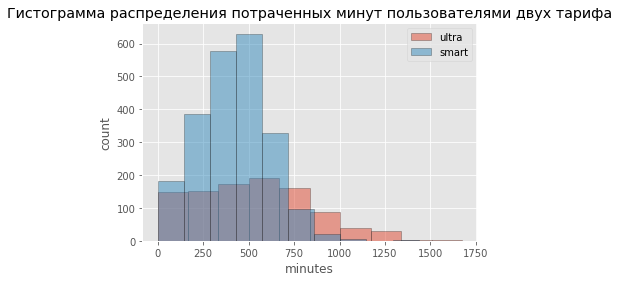

In [82]:
#построим гистограмму распределения потраченных минут 
stat_users.query('tariff == "ultra"')['total_minutes'].hist(edgecolor = 'black', alpha = 0.5)
stat_users.query('tariff == "smart"')['total_minutes'].hist(edgecolor = 'black', alpha = 0.5)
plt.xlabel('minutes');
plt.title('Гистограмма распределения потраченных минут пользователями двух тарифа')
plt.ylabel('count');
plt.legend(('ultra','smart'), loc='best');

Предлагаю ещё взглянуть, как изменяется значение минут, используемое клиентами телекомпании, на протяжении года. Для этого сгруппируем нашу таблицу и построим столбчатую диаграмму.

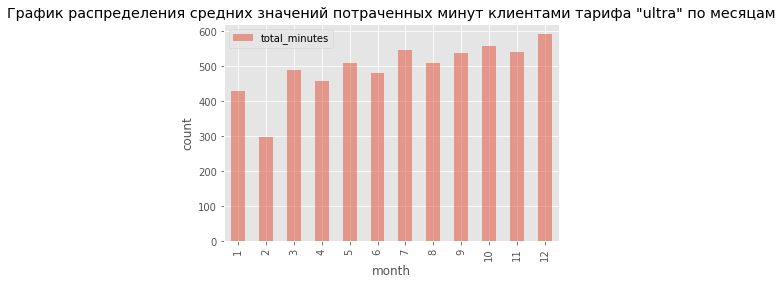

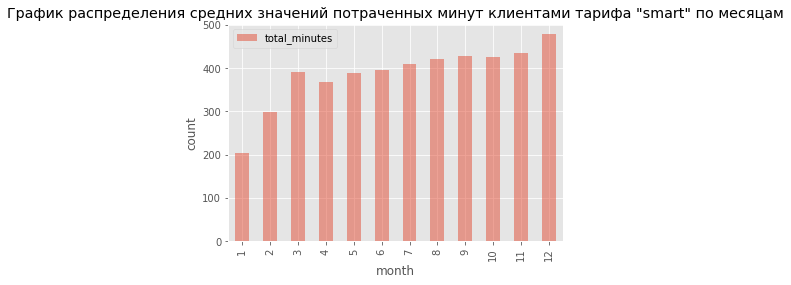

In [64]:
stat_users.pivot_table(
    index = ['tariff', 'month'], values = 'total_minutes'
).reset_index('month').query('tariff == "ultra"').plot.bar(
    x = 'month',
    y = 'total_minutes',
    alpha = 0.5,
    title = 'График распределения средних значений потраченных минут клиентами тарифа "ultra" по месяцам',
)
plt.legend(loc='best')

plt.ylabel('count');
stat_users.pivot_table(
    index = ['month', 'tariff'], values = 'total_minutes'
).reset_index('month').query('tariff == "smart"').plot.bar(
    x = 'month',
    y = 'total_minutes',
    alpha = 0.5,
    title = 'График распределения средних значений потраченных минут клиентами тарифа "smart" по месяцам',
)
plt.legend(loc='best')
plt.ylabel('count');

Клиенты "Мегалайн", которые подключены к тарифу 'ultra', в среднем в месяц расходуют 530 минут, а те, кто подключен к тарифу 'smart', в среднем в месяц расходуют 420 минут. На гистограмме видно, что в тарифе 'smart' люди чаще всего расходуют 300 - 600 мин, пик лежит около 500 мин. А в тарифе 'ultra', равномерно распределено количество людей, которые расходуют от 0 до 800 мин. в месяц. ещё, в отличии от тарифа 'smart', тарифом 'ultra' пользуются небольшое количество человек, которые в месяц тратят до 1750 минут (об этом говорит нам хвост на гистограмме, это наши выбросы). Так же хочется заметить, что вне зависимости от тарифа, можно наблюдать, что среднее количество потраченных в месяц минут со временем растет. Это можно наблюдать на графике распределения минут по месяцам.

Переходим к следующей характеристике, а именно к количеству сообщений, отправленных клиентами 'Мегалайн'.

In [65]:
#расчеты для значений столбца 'total_minutes'

mean_ultra_messages = stat_users_ultra['total_messages'].mean()
d_ultra_messages = np.var(stat_users_ultra['total_messages'])
s_ultra_messages = np.std(stat_users_ultra['total_messages'])
print('Данные отправленных сообщений по клиентам тарифа "ultra":')
print(f'Среднее значение: {mean_ultra_messages}')
print(f'Дисперсия: {d_ultra_messages}')
print(f'Стандартное отклонение: {s_ultra_messages}')

Данные отправленных сообщений по клиентам тарифа "ultra":
Среднее значение: 49.36345177664975
Дисперсия: 2282.9460753948824
Стандартное отклонение: 47.78018496610161


In [66]:
mean_smart_messages = stat_users_smart['total_messages'].mean()
d_smart_messages = np.var(stat_users_smart['total_messages'])
s_smart_messages = np.std(stat_users_smart['total_messages'])
print('Данные отправленных сообщений по клиентам тарифа "smarta":')
print(f'Среднее значение: {mean_smart_messages}')
print(f'Дисперсия: {d_smart_messages}')
print(f'Стандартное отклонение: {s_smart_messages}')

Данные отправленных сообщений по клиентам тарифа "smarta":
Среднее значение: 33.384028712427096
Дисперсия: 796.455482917076
Стандартное отклонение: 28.221542886898938


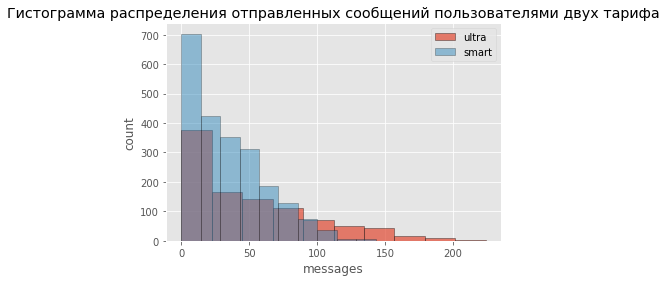

In [80]:
#построим гистограмму распределения отправленных сообщений
stat_users.query('tariff == "ultra"')['total_messages'].hist(edgecolor = 'black', alpha = 0.7)
stat_users.query('tariff == "smart"')['total_messages'].hist(edgecolor = 'black', alpha = 0.5)
plt.title('Гистограмма распределения отправленных сообщений пользователями двух тарифа');
plt.xlabel('messages');
plt.ylabel('count');
plt.legend(('ultra','smart'), loc='best');

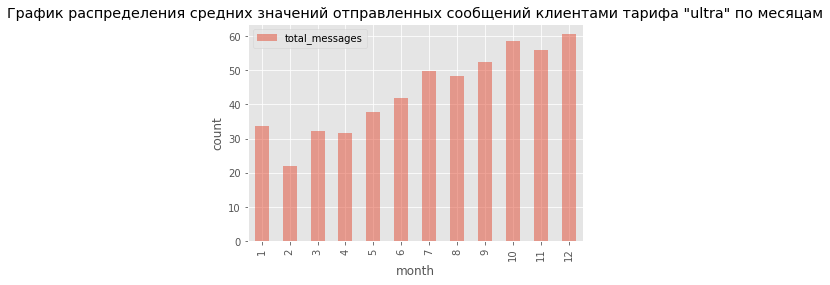

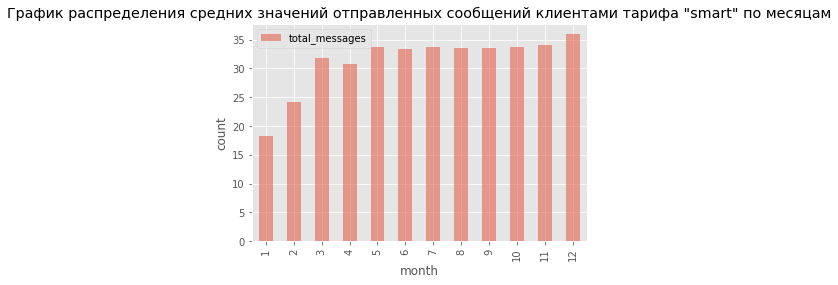

In [68]:
stat_users.pivot_table(
    index = ['tariff', 'month'], values = 'total_messages'
).reset_index('month').query('tariff == "ultra"').plot.bar(
    x = 'month',
    y = 'total_messages',
    alpha = 0.5,
    title = 'График распределения средних значений отправленных сообщений клиентами тарифа "ultra" по месяцам',
)
plt.legend(loc='best')

plt.ylabel('count');
stat_users.pivot_table(
    index = ['month', 'tariff'], values = 'total_messages'
).reset_index('month').query('tariff == "smart"').plot.bar(
    x = 'month',
    y = 'total_messages',
    alpha = 0.5,
    title = 'График распределения средних значений отправленных сообщений клиентами тарифа "smart" по месяцам',
)
plt.legend(loc='best')
plt.ylabel('count');

В среднем в месяц клиенты, подключенные к 'ultra', отправляют по 50 сообщений, а клиенты, подключенные к 'smart', по 33 сообщения. Вне зависимости от тарифа, по гистограмме можно наблюдать хвост, это люди, которые в месяц отправляют сильно больше остальных. На гистограмме распределения тарифа "ultra', этот хвост тянется, больше, чем у другого тарифа, и даже превышает отметка 200 сообщений в день. Кажется, надо рассказать им о мессенджерах. Так же, как и в ситуации со звонками, с ходом времени виден рост среднего количества отправленных сообщений в месяц.

Приступим к анализу последней характеристики, к объёму потраченного интернет-трафика.

In [69]:
#расчеты для значений столбца 'internet_used'

mean_ultra_internet = stat_users_ultra['internet_used'].mean()
d_ultra_internet = np.var(stat_users_ultra['internet_used'])
s_ultra_internet = np.std(stat_users_ultra['internet_used'])
print('Данные объема потраченного интернет-трафика по клиентам тарифа "ultra":')
print(f'Среднее значение: {mean_ultra_internet}')
print(f'Дисперсия: {d_ultra_internet}')
print(f'Стандартное отклонение: {s_ultra_internet}')

Данные объема потраченного интернет-трафика по клиентам тарифа "ultra":
Среднее значение: 19.494416243654822
Дисперсия: 96.99311602978692
Стандартное отклонение: 9.848508314957495


In [70]:
mean_smart_internet = stat_users_smart['internet_used'].mean()
d_smart_internet = np.var(stat_users_smart['internet_used'])
s_smart_internet = np.std(stat_users_smart['internet_used'])
print('Данные объема потраченного интернет-трафика по клиентам тарифа "smart":')
print(f'Среднее значение: {mean_smart_internet}')
print(f'Дисперсия: {d_smart_internet}')
print(f'Стандартное отклонение: {s_smart_internet}')

Данные объема потраченного интернет-трафика по клиентам тарифа "smart":
Среднее значение: 16.328847016599372
Дисперсия: 33.013887454837445
Стандартное отклонение: 5.745771267187499


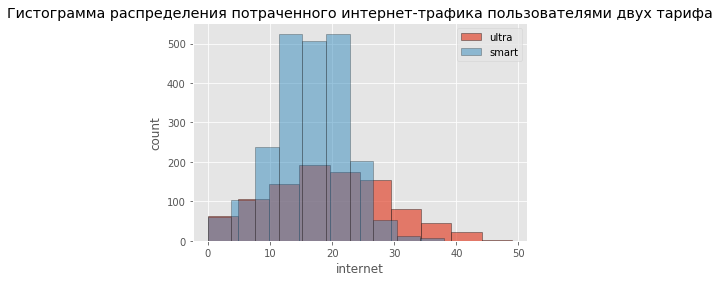

In [83]:
#построим гистограмму распределения потраченного интернет-трафика
stat_users.query('tariff == "ultra"')['internet_used'].hist(edgecolor = 'black', alpha = 0.7)
stat_users.query('tariff == "smart"')['internet_used'].hist(edgecolor = 'black', alpha = 0.5)
plt.xlabel('internet');
plt.ylabel('count');
plt.title('Гистограмма распределения потраченного интернет-трафика пользователями двух тарифа');
plt.legend(('ultra','smart'), loc='best');

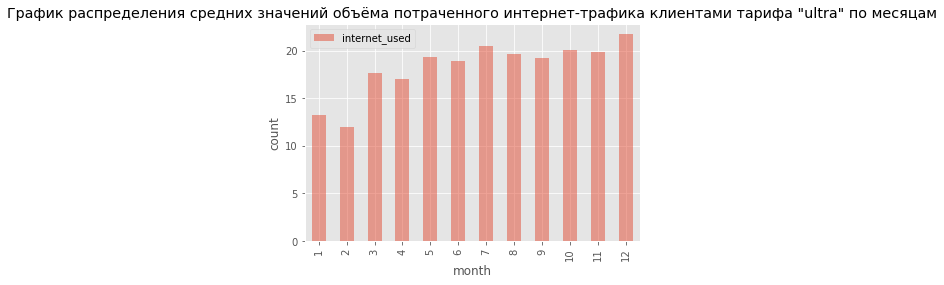

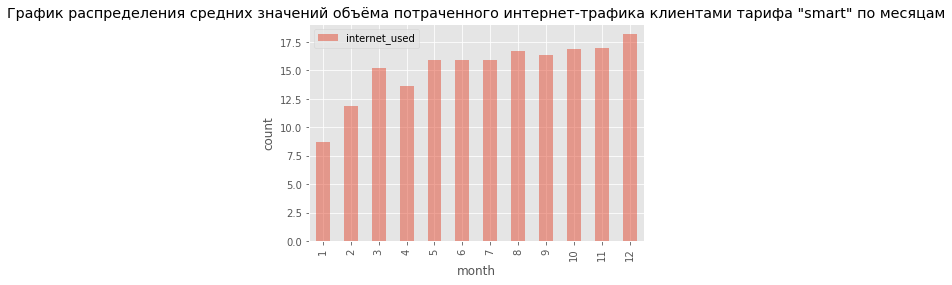

In [72]:
stat_users.pivot_table(
    index = ['tariff', 'month'], values = 'internet_used'
).reset_index('month').query('tariff == "ultra"').plot.bar(
    x = 'month',
    y = 'internet_used',
    alpha = 0.5,
    title = 'График распределения средних значений объёма потраченного интернет-трафика клиентами тарифа "ultra" по месяцам',
)
plt.legend(loc='best')

plt.ylabel('count');
stat_users.pivot_table(
    index = ['month', 'tariff'], values = 'internet_used'
).reset_index('month').query('tariff == "smart"').plot.bar(
    x = 'month',
    y = 'internet_used',
    alpha = 0.5,
    title = 'График распределения средних значений объёма потраченного интернет-трафика клиентами тарифа "smart" по месяцам',
)
plt.legend(loc='best')
plt.ylabel('count');

Что можно сказать об объёме потраченного интернет трафика пользователями двух тарифов? В среднем пользователи тарифа 'ultra' тратят 19.5 гигабайт интернета, а пользователи тарифа 'smart’ 16 гигабайт. Это значит, что в среднем пользователи тарифа 'smart', в отличии от других, платят за дополнительной объём интернет-трафика. Пик у пользователей тарифа 'ultra' лежит около 17 гигабайт, у пользователей тарифа 'smart' пик лежит примерно в тех же значений, но он шире. Так же, как и в других случаях, интернет-трафик не исключение. В отличие от тарифа 'smart', среди пользователей тарифа 'ultra' есть люди, которые используют все возможности интернета, из-за чего они пользуются огромным объёмом интернет-трафика. График распределения средних значений по месяцам так же дает идентичный с прошлыми экспериментами результат, с ходом времени людям необходимо все больше объёма интернет-трафика.

### Вывод

В этом разделе изучили поведение клиентов. Подробно разобрали следующие характеристики: какое количество минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц. Сделали некоторые выводы. Самое простое: по диаграмме распределения средних значений наших характеристик по месяцам наблюдается рост всех параметров. Это значит, что с ходом времени люди все активнее начинают пользоваться своими смартфонами, звонить, писать сообщения, пользоваться чудесами интернета. Ещё один вывод: пользователи тарифа 'smart' чаще покупают дополнительные минуты, сообщения и гигабайты. Особенно это видно по расходу интернет-трафика. Среднее значение расхода интернет-трафика у пользователей тарифа 'smart' равно 16 гигабайт, что превышает объём, который прописан в тарифном плане. Возможно, эти люди хотят так сэкономить, они не готовы платить за тариф 'ultra'. А вот пользователи тарифа 'ultra' хоть и превышают тарифный план 'smart', но свой они почти никогда не превышают. Но кто же из них прав? Кто переплачивает? Пока мы можем сказать лишь о том, что пользователи тарифа 'smart' в среднем платят меньше.

## Проверка гипотез

В этом разделе мы проверим следующие гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

Давайте проверим гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Формируем нулевую гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт». Её мы будем формировать на основе равенства, так как использовать мы будем метод st.ttest_ind(). Значение st.ttest_ind().pvalue мы будем сравнивать со значением равным 0.05, так как он характеризует лишь 5% случаев, если 5% будут выбиваться из общей картины, это не будет повод отвергать гепотезу о равенстве в целом(среднем).

Формируем альтернативную гипотезу, если не произойдет нулевая гипотеза, то произойдет следующее: средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [75]:
# строим выборки, которые мы будем сравнивать
proceeds_from_smart = stat_users.query('tariff == "smart"')['total_costs']
proceeds_from_ultra = stat_users.query('tariff == "ultra"')['total_costs']

In [76]:
# Проверим равенство наших двух совакупностей и выведем результат

alpha = .05

results = st.ttest_ind(proceeds_from_smart, proceeds_from_ultra, equal_var = True)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.4229814360764067e-160
Отвергаем нулевую гипотезу


Вероятность того, что средняя выручка пользователей тарифов «Ультра» и «Смарт» будет одинакова, слишком мала, меньше процента. Об этом нам говорит результат выполнения метода st.ttest_ind(), который проверяет две совокупности на равенство. Из-за этого мы подтверждаем гипотезу о том, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

Тепрь проверим, отличается ли средняя вырочка от пользователей из москвы от выручки пользователей из других регионов.

Формируем нулевую гипотезу: средняя выручка пользователи из Москвы не отличается от выручки пользователей из других регионов.

Формируем альтернативную гипотезу: средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.

Для того, чтобы проверить нашу гипотезу, добавим новый столбец с название города в таблицу 'stat_users'.

In [77]:
users_city = users['user_id'].to_frame()
users_city['city'] = users['city']
stat_users = stat_users.merge(users_city, on = 'user_id')
stat_users.head(10)

,user_id,month,count_calls,total_minutes,total_messages,internet_used,tariff,churn_date,total_costs,city
0,1000,5,17,159,22,3,ultra,2019-01-01,1950,Краснодар
1,1000,6,28,172,60,23,ultra,2019-01-01,1950,Краснодар
2,1000,7,41,340,75,14,ultra,2019-01-01,1950,Краснодар
3,1000,8,42,408,81,14,ultra,2019-01-01,1950,Краснодар
4,1000,9,46,466,57,15,ultra,2019-01-01,1950,Краснодар
5,1000,10,44,350,73,15,ultra,2019-01-01,1950,Краснодар
6,1000,11,37,338,58,15,ultra,2019-01-01,1950,Краснодар
7,1000,12,38,333,70,10,ultra,2019-01-01,1950,Краснодар
8,1001,11,45,430,0,18,smart,2019-01-01,1150,Москва
9,1001,12,47,414,0,14,smart,2019-01-01,550,Москва


In [78]:
#Строим выборки по городу, для проверки гипотезы
proceeds_from_mocsow = stat_users.query('city == "Москва"')['total_costs']
proceeds_from_other = stat_users.query('city != "Москва"')['total_costs']

In [79]:
# Проверим равенство средних наших двух совакупностей и выведем результат

alpha = .05

results = st.ttest_ind(proceeds_from_mocsow, proceeds_from_other)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


Мы не можем не отвергнуть гипотезу о том, что средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов. Такое решение нам помог принять метод st.ttest_ind(), результатом его работы стало значение примерно равное 0.54. О чем это говорит? Что в 54% случаев Выручка с клиентов из Москвы равна выручке с клиентов из остальных регионов.

### Вывод
Что можно сказать о работе в этом разделе? Все просто: 
* первую гипотезу: "средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются", мы не можем отвергнуть, так как одинаковая выручка с клиентов двух тарифов гипотезу меньше чем в 1% случаев.
* вторую гипотезу: "средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов." Её мы не можем подтвердить, ведь в 54% случаев выручка с клиентов из города Москва равна выручке с клиентов из других регионов.


## Общий вывод
Вот и подошла к концу наша работа. Первую часть работы мы обрабатывали наши данные, высчитывали новые, нужные для анализа, значения и собрали их в одну таблицу. Затем начался анализ. В нем мы рассчитывали: сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Нашли закономерность, что с каждым месяцем растет объём минут, сообщений, интернет-трафика, который необходим пользователям. Так же мы построили графики распределения минут, сообщений, интернет-трафика, которые расходуют пользователи двух тарифов каждый месяц. Определили, что пользователи тарифа 'ultra' в среднем пользуются тремя исследуемыми факторами в большем количестве, чем пользователи тарифа 'ultra'. Так же в этом тарифе чаще встречаются люди, которые пользуются услугами телекомпании на полную ногу. Но при этом им чаще всего хватает тарифного плана, они реже переплачивают, когда пользователи тарифа 'ultra' этим грешат чаще. Затем мы проверили две гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователи из Москвы чаще равна выручке пользователей из других регионов.
Ни одну из них не отвергнуть у нас не получилось, но результат я назвал бы логичным. 

В результате работы, стало понятно, что на данный момент пользователи тарифа 'smart' в общем приносят больше, чем пользователи тарифа 'ultra', но это ещё ничего не говорит. Хоть они и чаще платят за дополнительные минуты разговора, сообщения и объём интернет-трафика, но в среднем их затраты за теле обслуживание не превышают средние затраты участников тарифа 'ultra'. Я бы не советовал делать упор на крупные регионы, выручка с клиентов из крупных городов как Москва, скорее не отличается от средней выручки с клиентов из других регионов. А посоветовал бы я рекламной компании сделать больший упор на привлечение клиентов к тарифу 'ultra', а в рекламной компании можно использовать слоган что-то вроде: 'зачем вам переплачивать, если можно один раз заплатить'. Ладно... Плохой из меня маркетолог, но суть я, как мне кажется, объяснил. А я пошел кодить.
